<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP062_053.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Tue May 24 08:30:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null
    !pip install geopy > /dev/null

    # for gpu
    # !git clone --recursive https://github.com/Microsoft/LightGBM
    # %cd /content/LightGBM/
    # !mkdir build
    # !cmake -DUSE_GPU=1 
    # !make -j$(nproc)
    # !sudo apt-get -y install python-pip

    # !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    # #pandasのエラーが出る場合は上記のコードからpandasを削除

    # !sudo -H pip install setuptools numpy scipy scikit-learn -U
    # %cd /content/LightGBM/python-package
    # !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein
import ephem
from geopy.distance import geodesic
import pickle

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP062-053


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


In [10]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


#### Load oof

In [11]:
notes = ["FP056-50", "FP061-060"]

In [12]:
oof_dfs = []
submit_dfs = []

for n in notes:
    oof_df = pd.read_csv(os.path.join(BASE_DIR, "oof", n, "oof.csv"))
    submit_df = pd.read_csv(os.path.join(BASE_DIR, "submission", n , "submission.csv"), names = ["id", "pm25_mid"])

    oof_dfs.append(oof_df)
    submit_dfs.append(submit_df)

In [13]:
oof_df

,id,pm25_mid,kfold,oof
0,1,19.901,8,17.226259
1,2,13.741,0,25.640156
2,3,25.918,1,29.871767
3,4,174.370,6,131.482178
4,5,167.063,0,148.062607
...,...,...,...,...
195936,195937,16.150,4,30.709837
195937,195938,16.895,9,27.124138
195938,195939,86.299,7,58.305237
195939,195940,36.523,1,41.718170


In [14]:
mean_oof = pd.DataFrame()

mean_oof["id"] = oof_df["id"]
mean_oof["pm25_mid"] = oof_df["pm25_mid"]
mean_oof["oof"] = 0

for w_0 in range(11):
    mean_oof["oof"] = 0
    weights = [w_0 * 0.1, 1 - w_0*0.1]
    print(weights)
    for i, oof_df in enumerate(oof_dfs):
        w = weights[i]
        mean_oof["oof"] += oof_df["oof"] * w
    print(np.sqrt(mean_squared_error(mean_oof["pm25_mid"], mean_oof["oof"])))

[0.0, 1.0]
21.14421669104968
[0.1, 0.9]
21.123151525791926
[0.2, 0.8]
21.105285838336926
[0.30000000000000004, 0.7]
21.090627759435755
[0.4, 0.6]
21.0791839806264
[0.5, 0.5]
21.070959739032986
[0.6000000000000001, 0.3999999999999999]
21.06595880541968
[0.7000000000000001, 0.29999999999999993]
21.06418347556265
[0.8, 0.19999999999999996]
21.065634564985974
[0.9, 0.09999999999999998]
21.07031140708971
[1.0, 0.0]
21.078211854680067


In [32]:
mean_oof["oof"] = 0
mean_oof["pm25_mid"] = oof_dfs[0]["pm25_mid"]
weights = [0.5, 0.5]
for i in range(len(oof_dfs)):
    w = weights[i]
    mean_oof["oof"] += w * oof_dfs[i]["oof"]

oof_score = np.sqrt(mean_squared_error(mean_oof["pm25_mid"], mean_oof["oof"]))

oof_score = format(oof_score, ".4f")
print(f"oof score: {oof_score}")

oof score: 21.0710


In [33]:
mean_submit_df = pd.DataFrame()
mean_submit_df["id"] = submit_df["id"]
mean_submit_df["pm25_mid"] = 0

weights = [0.5, 0.5]
for i, submit_df in enumerate(submit_dfs):
    w = weights[i]
    mean_submit_df["pm25_mid"] += w * submit_df["pm25_mid"]

In [34]:
mean_submit_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

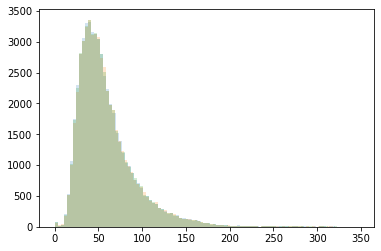

In [35]:
plt.hist(submit_dfs[0]["pm25_mid"], bins = 100, alpha = 0.2)
plt.hist(submit_dfs[1]["pm25_mid"], bins = 100, alpha = 0.2)
plt.hist(mean_submit_df["pm25_mid"], bins = 100, alpha = 0.2)

plt.show()

# submit

In [36]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

mkdir: cannot create directory ‘/root/.signate’: File exists


In [37]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [38]:
submission_file

'/content/drive/MyDrive/signate/air_pollutants/submission/FP062-053/submission.csv'

In [39]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:21.0710_FP062-053'

# Submit

In [40]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions

In [24]:
train_df[["City", "month", "pm25_mid"]].groupby(["City"]).describe()

month                                                pm25_mid  \
              count      mean       std  min  25%  50%   75%   max    count   
City                                                                          
Adapazarı     962.0  6.536383  3.356269  1.0  4.0  6.0   9.0  12.0    962.0   
Akita         978.0  6.527607  3.436774  1.0  4.0  6.0  10.0  12.0    978.0   
Albuquerque   917.0  6.679389  3.347707  1.0  4.0  7.0  10.0  12.0    917.0   
Andong       1011.0  6.608309  3.431492  1.0  4.0  7.0  10.0  12.0   1011.0   
Antakya       734.0  6.779292  3.200069  1.0  4.0  7.0  10.0  12.0    734.0   
...             ...       ...       ...  ...  ...  ...   ...   ...      ...   
Zhuzhou      1059.0  6.610954  3.425374  1.0  4.0  7.0  10.0  12.0   1059.0   
Ürümqi       1033.0  6.642788  3.399611  1.0  4.0  7.0  10.0  12.0   1033.0   
İzmit        1013.0  6.553801  3.346923  1.0  4.0  7.0   9.0  12.0   1013.0   
Łódź          753.0  6.701195  3.238681  1.0  4.0  7.0   9.0  12.0    753.0   
Ōita         1057.0  6.621570  3.406298  1.0  4.0  7.0  10.0  12.0   1057.0   

                                                                         \
                  mean        std     min       25%      50%        75%   
City                                                                      
Adapazarı    63.232831  35.395245   6.460  39.56125  55.6930   73.47475   
Akita        45.871133  25.458542   6.364  28.59525  40.5160   57.69725   
Albuquerque  42.865439  28.188976   7.736  22.31000  34.6630   57.03700   
Andong       59.396874  31.321281   6.600  37.84050  56.9850   69.45200   
Antakya      58.372569  41.630375   2.125  27.77575  53.3615   68.76650   
...                ...        ...     ...       ...      ...        ...   
Zhuzhou      88.612365  43.927142  13.978  57.70200  75.5570  117.65500   
Ürümqi       81.598576  57.824517   9.867  47.92700  61.1770   92.37700   
İzmit        57.312069  29.037306   8.437  36.52600  54.2140   68.27100   
Łódź         61.209457  30.803510  11.894  40.49800  56.6420   73.41000   
Ōita         43.637044  20.845038   6.685  26.33400  40.2000   57.08000   

                      
                 max  
City                  
Adapazarı    181.469  
Akita        218.085  
Albuquerque  173.738  
Andong       191.630  
Antakya      286.452  
...              ...  
Zhuzhou      236.485  
Ürümqi       406.464  
İzmit        176.600  
Łódź         216.704  
Ōita         135.558  

[239 rows x 16 columns]

In [25]:
test_df__[["IDW_p1_pm25_mid", "IDW_p2_pm25_mid"]]

NameError: ignored

In [ ]:
train_df[["co_cnt", "co_var", "co_min", "co_max", "co_mid"]]

In [ ]:
gen = np.random.default_rng()

rnd = gen.normal(size=38)

print(len(rnd), rnd.mean(), rnd.std())

In [ ]:
plt.hist(train_df[train_df["City"] == "Adapazarı"]["pm25_mid"], bins = 100)